# Analysing Fraudulent Transaction Data

## Table of Contents
* [Part 1 : Working with RDD](#part-1)  
    - [1.1 Data Preparation and Loading](#1.1)  
    - [1.2 Data Partitioning in RDD](#1.2)  
    - [1.3 Query/Analysis](#1.3)  
* [Part 2 : Working with DataFrames](#2-dataframes)  
    - [2.1 Data Preparation and Loading](#2-dataframes)  
    - [2.2 Query/Analysis](#2.2)  
* [Part 3 :  RDDs vs DataFrame vs Spark SQL](#part-3)  

# Part 1 : Working with RDDs  <a class="anchor" name="part-1"></a>
## 1.1 Working with RDD
In this section, we will need to create RDDs from the given datasets, perform partitioning in these RDDs and use various RDD operations to answer the queries. 

1.1.1 Data Preparation and Loading <a class="anchor" name="1.1"></a>
Write the code to create a SparkContext object using SparkSession. To create a SparkSession you first need to build a SparkConf object that contains information about your application, use Melbourne time as the session timezone. Give an appropriate name for your application and run Spark locally with 4 cores on your machine. 

In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkConf

# Setting up Spark session and Spark context
conf = SparkConf().setAppName("FraudDetectionAssignment").setMaster("local[4]").set("spark.sql.session.timeZone", "Australia/Melbourne")
spark = SparkSession.builder.config(conf=conf).getOrCreate()
sc = spark.sparkContext

1.1.2 Load csv files into multiple RDDs.

In [2]:
# Loading the CSV files into RDDs
transactions_rdd = sc.textFile("transactions.csv")
customers_rdd = sc.textFile("customers.csv")
merchants_rdd = sc.textFile("merchant.csv")
geolocation_rdd = sc.textFile("geolocation.csv")
category_rdd = sc.textFile("category.csv")

1.1.3 For each RDD, remove the header rows and display the total count and first 10 records. (Hint: You can use csv.reader to parse rows into RDDs.)

In [3]:
# Defining a function to remove header and display count and first 10 records
def process_rdd(rdd):
    header = rdd.first()  # Getting the first row as header
    rdd_cleaned = rdd.filter(lambda row: row != header)  # Filtering out the header from the RDD
    total_count = rdd_cleaned.count()  # Counting the total number of records in the cleaned RDD
    first_10_records = rdd_cleaned.take(10)  # Taking the first 10 records from the cleaned RDD
    return rdd_cleaned, total_count, first_10_records  # Returning the cleaned RDD, total count, and first 10 records

# Processing each RDD and storing the cleaned RDDs
transactions_rdd_cleaned, transactions_count, transactions_first_10 = process_rdd(transactions_rdd)  
customers_rdd_cleaned, customers_count, customers_first_10 = process_rdd(customers_rdd)  
merchants_rdd_cleaned, merchants_count, merchants_first_10 = process_rdd(merchants_rdd)  
geolocation_rdd_cleaned, geolocation_count, geolocation_first_10 = process_rdd(geolocation_rdd)  
category_rdd_cleaned, category_count, category_first_10 = process_rdd(category_rdd)  

# Printing results
print(f"Transactions: Total Records = {transactions_count}\n\nFirst 10 Records = {transactions_first_10}\n\n")  
print(f"Customers: Total Records = {customers_count}\n\nFirst 10 Records = {customers_first_10}\n\n")  
print(f"Merchants: Total Records = {merchants_count}\n\nFirst 10 Records = {merchants_first_10}\n\n")  
print(f"Geolocations: Total Records = {geolocation_count}\n\nFirst 10 Records = {geolocation_first_10}\n\n")  
print(f"Categories: Total Records = {category_count}\n\nFirst 10 Records = {category_first_10}\n\n")  

Transactions: Total Records = 22949835

First 10 Records = ['"0c20530e90719213c442744161a1850b",1622367050,87.18,0,"794-45-4364",46,2641132,12', '"984fc48fc946605deefc9d0967582811",1609183538,276.97,0,"436-80-2340",60,2932280,5', 'b13ff47c73689bc4c8320c0ce403b15d,1655595319,7.67,0,"385-77-6544",87,2708770,2', '"7cffae35cab67d9415f9f22d91ca7acc",1613234460,198.96,0,"450-56-1117",138,1170872,10', '"22e01cb3403a4c7ce598ebe785e1e947",1605030979,33.46,0,"397-54-0253",218,2470519,5', '"1d174d018228efcd1d5800f768628904",1608989049,2.74,0,"248-09-7729",222,3436926,9', '"532536d65907e08d938cb31e3631ddd4",1650997797,1.23,0,"277-12-7638",337,3750746,2', '"32d76f65b7512afbdc99331ee96bc6d7",1649986601,7.78,0,"615-63-3623",718,3773961,2', 'c3f29bca602c9e2e9a188567f06d632f,1617032215,218.8,0,"877-16-8226",747,2377216,10', 'c56ef2e4a43d867128839b97bc1dbb66,1609250028,62.1,0,"823-85-5801",950,652447,5']


Customers: Total Records = 10000

First 10 Records = ['"263-99-6044","4241904966319315",Melissa,Tu

1.1.4 Drop personal information columns from RDDs: cc_num, firstname, lastname, address. 

In [4]:
# Extracting the header and retain it for future use
header = customers_rdd.first()

# Splitting the header to get column names
header_columns = header.split(",")

# Cleaning the header by removing the double quotes
header_columns = [col.strip('"') for col in header.split(",")]

# Creating a dictionary to map column names to their index
column_indices = {column_name: index for index, column_name in enumerate(header_columns)}

# Indices of columns to drop: cc_num, firstname, lastname, address
columns_to_drop = ['cc_num', 'firstname', 'lastname', 'address']
indices_to_drop = [column_indices[col] for col in columns_to_drop]

# Function to drop specific columns from the customers RDD
def drop_columns(row, indices_to_drop):
    return [value for index, value in enumerate(row.split(",")) if index not in indices_to_drop]

# Applying the function to drop personal information from the customers RDD
customers_rdd_cleaned = customers_rdd.map(lambda row: drop_columns(row, indices_to_drop))

# Converting the cleaned RDD back to comma-separated strings
customers_rdd_cleaned = customers_rdd_cleaned.map(lambda row: ",".join(row))

# Removing the Header Before Printing
customers_rdd_cleaned = customers_rdd_cleaned.filter(lambda row: row != ",".join(drop_columns(header, indices_to_drop)))

# Displaying the first 10 records after dropping personal information columns
customers_first_10_after_drop = customers_rdd_cleaned.take(10)
print("First 10 records of customers after dropping personal information columns:\n")
for record in customers_first_10_after_drop:
    print(record)

First 10 records of customers after dropping personal information columns:

"263-99-6044",F,Risk manager,"2005-05-30",376443331852,6339
"292-61-7844",M,Trading standards officer,"2003-04-19",870143739098,6200
"491-28-3311",F,Optometrist,"2002-04-17",965855026307,3547
"826-23-1754",F,Banker,"2001-07-15",11324746755,6302
"172-11-9264",F,Sports coach,"2003-11-21",113495175185,5227
"150-95-7922",F,Medical secretary,"2006-03-06",719783599768,4047
"841-99-2980",M,Toxicologist,"2005-07-01",908554315130,6271
"705-41-6699",F,Product manager,"2003-01-23",772162574642,6302
"016-22-4524",F,"Loss adjuster, chartered","2001-08-26",982712248618,5614
"639-46-2126",F,Hydrologist,"2005-02-10",603471636817,6328


### 1.2 Data Partitioning in RDD <a class="anchor" name="1.2"></a>
1.2.1 For each RDD, print out the total number of partitions and the number of records in each partition.

In [5]:
# Function to print partition info
def print_partition_info(rdd):
    num_partitions = rdd.getNumPartitions()  # Getting the number of partitions in the RDD
    partition_sizes = rdd.glom().map(len).collect()  # Mapping each partition to its size and collecting the results
    return num_partitions, partition_sizes  # Returning the number of partitions and the sizes of each partition

# Printing partition info for each RDD
transactions_partitions, transactions_sizes = print_partition_info(transactions_rdd_cleaned)
customers_partitions, customers_sizes = print_partition_info(customers_rdd_cleaned)
merchants_partitions, merchants_sizes = print_partition_info(merchants_rdd_cleaned)
geolocation_partitions, geolocation_sizes = print_partition_info(geolocation_rdd_cleaned)
category_partitions, category_sizes = print_partition_info(category_rdd_cleaned)

# Printing results
print(f"Transactions: Number of Partitions = {transactions_partitions}\n\nSizes = {transactions_sizes}\n\n")
print(f"Customers: Number of Partitions = {customers_partitions}\n\nSizes = {customers_sizes}\n\n")
print(f"Merchants: Number of Partitions = {merchants_partitions}\n\nSizes = {merchants_sizes}\n\n")
print(f"Geolocations: Number of Partitions = {geolocation_partitions}\n\nSizes = {geolocation_sizes}\n\n")
print(f"Categories: Number of Partitions = {category_partitions}\n\nSizes = {category_sizes}\n\n")

Transactions: Number of Partitions = 56

Sizes = [409654, 409552, 409551, 409568, 409556, 409615, 409623, 409562, 409556, 409568, 409558, 409590, 409620, 409626, 409575, 409576, 409570, 409576, 409544, 409653, 409581, 409577, 409557, 409565, 409576, 409604, 409617, 409570, 409541, 409582, 409562, 409584, 409654, 409598, 409547, 409578, 409581, 409574, 409564, 409657, 409580, 409565, 409561, 409583, 409557, 409596, 409630, 409566, 409568, 409558, 409582, 409555, 409599, 409657, 409563, 422753]


Customers: Number of Partitions = 2

Sizes = [5002, 4998]


Merchants: Number of Partitions = 4

Sizes = [1094930, 1059961, 1059729, 622411]


Geolocations: Number of Partitions = 2

Sizes = [3178, 3164]


Categories: Number of Partitions = 2

Sizes = [6, 8]




1.2.2 Answer the following questions:   
a) How many partitions do the above RDDs have?   
b) How is the data in these RDDs partitioned by default, when we do not explicitly specify any partitioning strategy? Can you explain why it is partitioned in this number?   
c) Assuming we are querying the dataset based on transaction date, can you think of a better strategy to partition the data based on your available hardware resources?

#### Answer for a

Each RDD has a different number of partitions as observed in the earlier steps:

- Transactions RDD: 56 partitions
- Customers RDD: 2 partitions
- Merchants RDD: 4 partitions
- Geolocations RDD: 2 partitions
- Categories RDD: 2 partitions

#### Answer for b

When we create an RDD in Apache Spark without specifying a partitioning strategy, Spark automatically determines the number of partitions based on several factors:

Default Parallelism: The number of partitions is often decided by the spark.default.parallelism setting. In a standalone Spark mode or when using YARN, this default parallelism is usually equal to the total number of cores available across all nodes in our cluster. This ensures that Spark can maximize parallel execution by distributing the workload evenly across all CPU cores.

Input Data Size: The size of our input data also influences the number of partitions. For larger datasets, Spark may generate more partitions to break down the data into manageable chunks, facilitating efficient parallel processing. For instance, the Transactions RDD has 56 partitions, likely due to its large size, which allows for better distribution and load balancing across the cluster.

Default Behavior: If we do not specify the number of partitions explicitly while creating the RDDs, Spark relies on these internal configurations and the characteristics of the data to set the partition count. For example:
The Transactions RDD, being a large dataset, is partitioned into 56 partitions, which may correspond to a multiple of the available cores, optimizing parallelism.

Smaller datasets like Customers, Geolocations, and Categories have fewer partitions (2 or 4) since their smaller sizes do not necessitate extensive parallelization.
In summary, Spark partitions our data based on the default parallelism settings and the dataset's size, aiming to efficiently utilize cluster resources, minimize data shuffling, and enhance the performance of distributed computations.

#### Answer for c

When our queries focus on a specific attribute like the transaction date, optimizing the partitioning strategy around this attribute can significantly enhance performance. Here’s a better approach:

Date-Based Partitioning:
Instead of relying on the default partitioning, we could repartition the Transactions RDD based on the transaction date. This approach would group all transactions that occurred on the same date (or within the same date range, such as months or quarters) into the same partition. This is particularly useful for queries that filter data by date, as it localizes relevant data within fewer partitions, reducing the need to scan through unrelated data.

Hardware Considerations:
Number of Cores: If our cluster has a high number of CPU cores, we can afford to create more partitions, each corresponding to a specific date or range of dates. This allows us to leverage the full computational power of our hardware.

Memory: We should ensure that each partition is sized appropriately so that it fits comfortably within the available memory on each executor. Overly large partitions can cause out-of-memory errors, while too many small partitions can increase the overhead of task scheduling.

Balancing Load:
We should consider the distribution of transactions over time. If certain dates have significantly more transactions (e.g., holidays or sales events), we might want to create more fine-grained partitions for those dates to avoid skewed partitions, which could lead to some nodes being overburdened while others are underutilized.
We could use a partitioning strategy that creates more partitions for periods with higher transaction volumes (e.g., daily partitions for busy days, weekly for regular periods).

Data Locality:
By partitioning the data based on the transaction date, we increase the likelihood that related records (i.e., those within the same date range) are processed on the same node, reducing the need for expensive data shuffling across the network.

In summary, partitioning the data by transaction date can significantly optimize query performance, especially in scenarios where we frequently query by this attribute. This approach, combined with thoughtful consideration of our available hardware resources, will ensure efficient data processing and improved overall system performance.

1.2.3 Create a user defined function (UDF) to transform trans_timestamp to ISO format(YYYY-MM-DD hh:mm:ss), then call the UDF and add a new column trans_datetime.

In [6]:
from datetime import datetime

# Extracting the header and column names
header = transactions_rdd.first()

columns = [col.strip('"') for col in header.split(",")]  # Stripping quotes from column names

# UDF to transform UNIX timestamp to ISO format (assuming the timestamp is in seconds)
def to_iso_format(timestamp):
    return datetime.fromtimestamp(int(timestamp)).strftime('%Y-%m-%d %H:%M:%S')

# Function to map over each row in the RDD
def add_trans_datetime(row):
    # Split the row into columns
    cols = row.split(",")
    
    # Finding the index of the trans_timestamp column
    trans_timestamp_index = columns.index("trans_timestamp")
    
    # Converting the UNIX timestamp to ISO format
    trans_datetime = to_iso_format(cols[trans_timestamp_index])
    
    # Adding the new datetime value to the row
    new_row = row + "," + trans_datetime
    return new_row

# Applying the function to each row in the RDD
transactions_rdd_final = transactions_rdd_cleaned.map(add_trans_datetime)

# Displaying the first few records after adding the trans_datetime column

transactions_first_10_after_udf = transactions_rdd_final.take(10)
print("First 10 records after adding trans_datetime column:\n")

print(f"{','.join(columns + ['trans_datetime'])}")
print("-" * 110)

for record in transactions_first_10_after_udf:
    print(record)

First 10 records after adding trans_datetime column:

id_transaction,trans_timestamp,amt,is_fraud,id_customer,id_geolocation,id_merchant,id_category,trans_datetime
--------------------------------------------------------------------------------------------------------------
"0c20530e90719213c442744161a1850b",1622367050,87.18,0,"794-45-4364",46,2641132,12,2021-05-30 09:30:50
"984fc48fc946605deefc9d0967582811",1609183538,276.97,0,"436-80-2340",60,2932280,5,2020-12-28 19:25:38
b13ff47c73689bc4c8320c0ce403b15d,1655595319,7.67,0,"385-77-6544",87,2708770,2,2022-06-18 23:35:19
"7cffae35cab67d9415f9f22d91ca7acc",1613234460,198.96,0,"450-56-1117",138,1170872,10,2021-02-13 16:41:00
"22e01cb3403a4c7ce598ebe785e1e947",1605030979,33.46,0,"397-54-0253",218,2470519,5,2020-11-10 17:56:19
"1d174d018228efcd1d5800f768628904",1608989049,2.74,0,"248-09-7729",222,3436926,9,2020-12-26 13:24:09
"532536d65907e08d938cb31e3631ddd4",1650997797,1.23,0,"277-12-7638",337,3750746,2,2022-04-26 18:29:57
"32d76f65b7512a

### 1.3 Query/Analysis <a class="anchor" name="1.3"></a>
For this part, write relevant RDD operations to answer the following queries.

1.3.1 Calculate the summary of fraudulent transactions amount for each year, each month. Print the results in tabular format.

In [7]:
from datetime import datetime

header = transactions_rdd.first() # Getting the first row as header
header_columns = header.split(",") # Splitting the header into individual columns

# Creating a dictionary to map column names to their index
column_indices = {column_name.strip('"'): index for index, column_name in enumerate(header_columns)}

# Extracting the necessary column indices dynamically
trans_timestamp_idx = column_indices['trans_timestamp']
amt_idx = column_indices['amt']
is_fraud_idx = column_indices['is_fraud']

# Calculating the summary of fraudulent transactions amount for each year, each month
# Filtering rows where 'is_fraud' is '1'
# Mapping each row to a key-value pair of (year, month) and amount
# Extracting the year and month from 'trans_timestamp'
# Converting 'amt' to float
# Summing the amounts for each (year, month) key
# Sorting by (year, month)

summary_by_year_month = transactions_rdd_cleaned \
    .filter(lambda row: row.split(",")[is_fraud_idx] == '1') \
    .map(lambda row: (( 
        datetime.utcfromtimestamp(int(row.split(",")[trans_timestamp_idx])).strftime('%Y'),
        datetime.utcfromtimestamp(int(row.split(",")[trans_timestamp_idx])).strftime('%m')), 
        float(row.split(",")[amt_idx]))) \
    .reduceByKey(lambda a, b: a + b) \
    .sortByKey() \
    .collect()

# Printing the results in a complete tabular format 
print("Summary of fraudulent transactions by year and month:\n")
print("+------------+------------+--------------------------+")
print("| {:<10} | {:<10} | {:<24} |".format("Year", "Month", "Total Fraudulent Amt.($)"))
print("+------------+------------+--------------------------+")
for ((year, month), total_amt) in summary_by_year_month:
    print("| {:<10} | {:<10} | {:<24.2f} |".format(year, month, total_amt))
    print("+------------+------------+--------------------------+")


Summary of fraudulent transactions by year and month:

+------------+------------+--------------------------+
| Year       | Month      | Total Fraudulent Amt.($) |
+------------+------------+--------------------------+
| 2020       | 01         | 898993.87                |
+------------+------------+--------------------------+
| 2020       | 02         | 1055068.69               |
+------------+------------+--------------------------+
| 2020       | 03         | 864818.53                |
+------------+------------+--------------------------+
| 2020       | 04         | 797646.98                |
+------------+------------+--------------------------+
| 2020       | 05         | 925864.70                |
+------------+------------+--------------------------+
| 2020       | 06         | 983224.85                |
+------------+------------+--------------------------+
| 2020       | 07         | 904102.03                |
+------------+------------+--------------------------+
| 2020    

1.3.2 List 20 mechants that suffered the most from fraudulent activities(i.e. 20 highest amount of monetary loss).

In [8]:
import csv
from io import StringIO

# Function to split a row using csv reader to correctly handle commas within quotes
def parse_row(row):
    return next(csv.reader(StringIO(row)))

# Filtering fraudulent transactions and map to (merchant_id, (amount, geolocation_id))
fraud_transactions_rdd = transactions_rdd_cleaned \
    .filter(lambda row: parse_row(row)[3] == '1') \
    .map(lambda row: (parse_row(row)[6], (float(parse_row(row)[2]), parse_row(row)[5])))

# Mapping merchants RDD to (merchant_id, (merchant_name, geolocation_id))
merchant_rdd = merchants_rdd_cleaned.map(lambda row: (parse_row(row)[2], (parse_row(row)[0], parse_row(row)[1])))

# Joining the transactions and merchants on merchant_id and geolocation_id
joined_rdd = fraud_transactions_rdd.join(merchant_rdd) \
    .filter(lambda x: x[1][0][1] == x[1][1][1]) \
    .map(lambda x: (x[1][1][0], x[1][0][0]))  # Mapping to (merchant_name, loss_amount)

# Aggregating losses by merchant name
loss_by_merchant = joined_rdd.reduceByKey(lambda a, b: a + b)

# Getting the top 20 merchants with the highest loss
top_20_merchants = loss_by_merchant.takeOrdered(20, key=lambda x: -x[1])

# Printing the top 20 merchants by total fraudulent loss in a tabular format
print("Top 20 Merchants by Total Fraudulent Loss:\n")
print("+---------------------------------+--------------------------+")
print("| {:<31} | {:<24} |".format("Merchant Name", "Total Loss ($)"))
print("+---------------------------------+--------------------------+")

for merchant, total_loss in top_20_merchants:
    print("| {:<31} | {:<24.2f} |".format(merchant, total_loss))
    print("+---------------------------------+--------------------------+")

Top 20 Merchants by Total Fraudulent Loss:

+---------------------------------+--------------------------+
| Merchant Name                   | Total Loss ($)           |
+---------------------------------+--------------------------+
| Kuhn LLC                        | 247132.85                |
+---------------------------------+--------------------------+
| Fisher-Schowalter               | 245249.72                |
+---------------------------------+--------------------------+
| Predovic Inc                    | 245216.96                |
+---------------------------------+--------------------------+
| Schumm PLC                      | 244274.90                |
+---------------------------------+--------------------------+
| Volkman-Predovic                | 242043.18                |
+---------------------------------+--------------------------+
| Bashirian Group                 | 241761.89                |
+---------------------------------+--------------------------+
| Labadie, 

## Part 2. Working with DataFrames  <a class="anchor" name="2-dataframes"></a>
In this section, we need to load the given datasets into PySpark DataFrames and use DataFrame functions to answer the queries.
### 2.1 Data Preparation and Loading

2.1.1. Load the CSV files into separate dataframes. When you create your dataframes, please refer to the metadata file and think about the appropriate data type for each column.

In [9]:
from pyspark.sql.types import *

# Defining the schema for each CSV file based on metadata (example schema)
transactions_schema = StructType([
    StructField("id_transaction", StringType(), True),
    StructField("trans_timestamp", LongType(), True),
    StructField("amt", FloatType(), True),
    StructField("is_fraud", IntegerType(), True),
    StructField("id_customer", StringType(), True),
    StructField("id_geolocation", IntegerType(), True),
    StructField("id_merchant", IntegerType(), True),
    StructField("id_category", IntegerType(), True)
])

customers_schema = StructType([
    StructField("id_customer", StringType(), True),
    StructField("cc_num", StringType(), True),
    StructField("firstname", StringType(), True),
    StructField("lastname", StringType(), True),
    StructField("gender", StringType(), True),
    StructField("address", StringType(), True),
    StructField("job", StringType(), True),
    StructField("dob", DateType(), True),
    StructField("acct_num", StringType(), True),
    StructField("id_geolocation", IntegerType(), True)
])

merchants_schema = StructType([
    StructField("merchant", StringType(), True),
    StructField("id_geolocation", IntegerType(), True),
    StructField("id_merchant", IntegerType(), True)
])

geolocation_schema = StructType([
    StructField("city", StringType(), True),
    StructField("state", StringType(), True),
    StructField("zip", StringType(), True),
    StructField("lat", FloatType(), True),
    StructField("long", FloatType(), True),
    StructField("id_geolocation", IntegerType(), True),
    StructField("population", IntegerType(), True)
])

category_schema = StructType([
    StructField("category", StringType(), True),
    StructField("id_category", IntegerType(), True)
])

# Loading DataFrames
transactions_df = spark.read.csv("transactions.csv", header=True, schema=transactions_schema)
customers_df = spark.read.csv("customers.csv", header=True, schema=customers_schema)
merchants_df = spark.read.csv("merchant.csv", header=True, schema=merchants_schema)
geolocation_df = spark.read.csv("geolocation.csv", header=True, schema=geolocation_schema)
category_df = spark.read.csv("category.csv", header=True, schema=category_schema)

2.1.2 Display the schema of the dataframes.

In [10]:
# Displaying schema for each DataFrame
transactions_df.printSchema()
customers_df.printSchema()
merchants_df.printSchema()
geolocation_df.printSchema()
category_df.printSchema()

root
 |-- id_transaction: string (nullable = true)
 |-- trans_timestamp: long (nullable = true)
 |-- amt: float (nullable = true)
 |-- is_fraud: integer (nullable = true)
 |-- id_customer: string (nullable = true)
 |-- id_geolocation: integer (nullable = true)
 |-- id_merchant: integer (nullable = true)
 |-- id_category: integer (nullable = true)

root
 |-- id_customer: string (nullable = true)
 |-- cc_num: string (nullable = true)
 |-- firstname: string (nullable = true)
 |-- lastname: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- address: string (nullable = true)
 |-- job: string (nullable = true)
 |-- dob: date (nullable = true)
 |-- acct_num: string (nullable = true)
 |-- id_geolocation: integer (nullable = true)

root
 |-- merchant: string (nullable = true)
 |-- id_geolocation: integer (nullable = true)
 |-- id_merchant: integer (nullable = true)

root
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: string (nullable = true)


Think about: When the dataset is large, do you need all columns? How to optimize memory usage? Do you need a customized data partitioning strategy? (note: You don’t need to answer these questions.)

### 2.2 QueryAnalysis  <a class="anchor" name="2.2"></a>
Implement the following queries using dataframes. You need to be able to perform operations like filtering, sorting, joining and group by using the functions provided by the DataFrame API.   

2.2.1. Transform the “trans_timestamp” to multiple columns: trans_year, trans_month, trans_day, trans_hour(24-hour format). (note: you can reuse your UDF from part 1 or create a new one.)

In [11]:
from pyspark.sql.functions import col, from_unixtime, year, month, dayofmonth, hour

# Transforming trans_timestamp to multiple columns
transactions_df = transactions_df.withColumn("trans_year", year(from_unixtime(col("trans_timestamp")))) \
                                 .withColumn("trans_month", month(from_unixtime(col("trans_timestamp")))) \
                                 .withColumn("trans_day", dayofmonth(from_unixtime(col("trans_timestamp")))) \
                                 .withColumn("trans_hour", hour(from_unixtime(col("trans_timestamp"))))

# Displaying the updated DataFrame
transactions_df.select("id_transaction", "trans_timestamp", "trans_year", "trans_month", "trans_day", "trans_hour").show(10)


+--------------------+---------------+----------+-----------+---------+----------+
|      id_transaction|trans_timestamp|trans_year|trans_month|trans_day|trans_hour|
+--------------------+---------------+----------+-----------+---------+----------+
|0c20530e90719213c...|     1622367050|      2021|          5|       30|        19|
|984fc48fc946605de...|     1609183538|      2020|         12|       29|         6|
|b13ff47c73689bc4c...|     1655595319|      2022|          6|       19|         9|
|7cffae35cab67d941...|     1613234460|      2021|          2|       14|         3|
|22e01cb3403a4c7ce...|     1605030979|      2020|         11|       11|         4|
|1d174d018228efcd1...|     1608989049|      2020|         12|       27|         0|
|532536d65907e08d9...|     1650997797|      2022|          4|       27|         4|
|32d76f65b7512afbd...|     1649986601|      2022|          4|       15|        11|
|c3f29bca602c9e2e9...|     1617032215|      2021|          3|       30|         2|
|c56

2.2.2. Calculate the total amount of fraudulent transactions for each hour. Show the result in a table and plot a bar chart.

+----------+--------------------+
|trans_hour|total_fraudulent_amt|
+----------+--------------------+
|0         |1870050.55          |
|1         |1813464.09          |
|2         |1922893.50          |
|3         |1956812.05          |
|4         |149472.43           |
|5         |148780.80           |
|6         |137913.87           |
|7         |150417.17           |
|8         |142853.59           |
|9         |139472.49           |
|10        |156019.69           |
|11        |143905.08           |
|12        |435847.47           |
|13        |406087.74           |
|14        |373030.29           |
|15        |427643.72           |
|16        |424106.05           |
|17        |422738.81           |
|18        |452547.24           |
|19        |447639.08           |
|20        |391790.53           |
|21        |436600.91           |
|22        |10170171.30         |
|23        |10199615.02         |
+----------+--------------------+



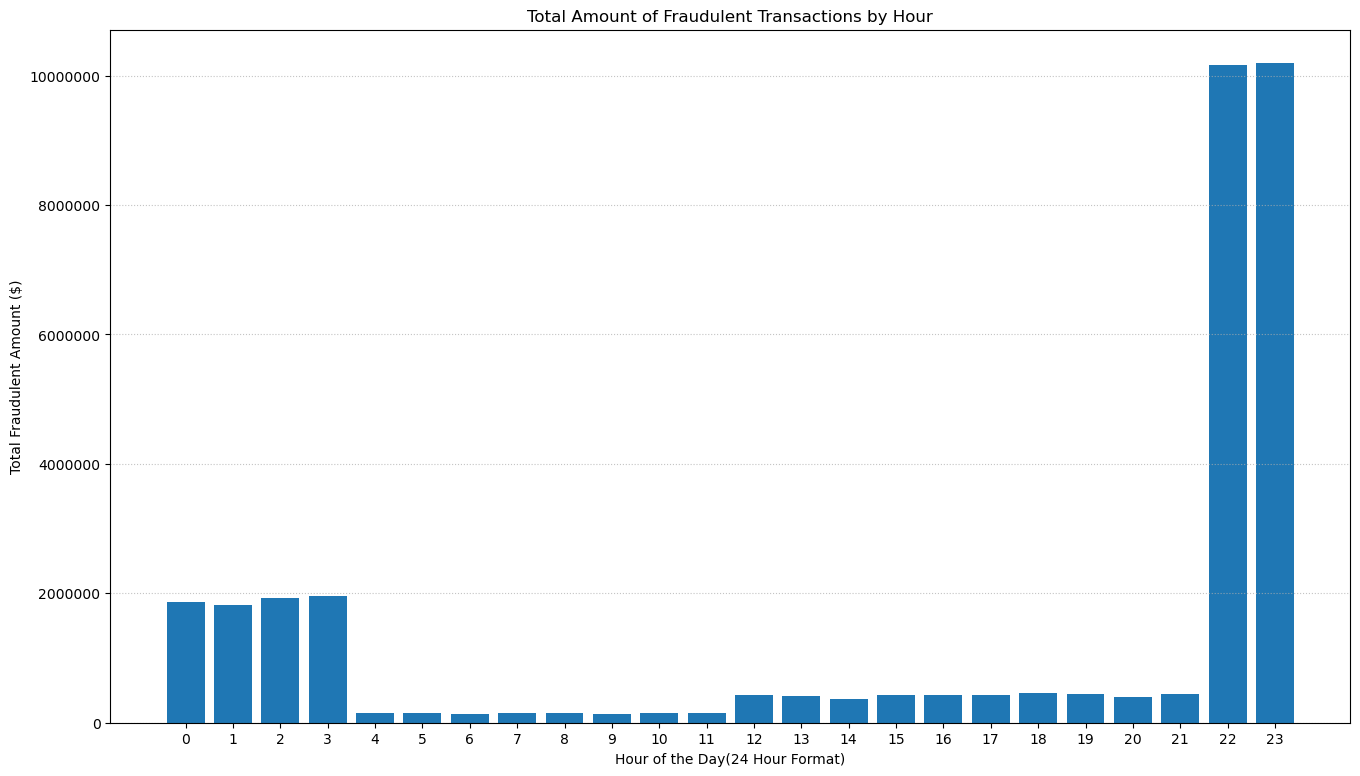

In [12]:
from pyspark.sql.functions import sum as spark_sum, udf

# Defining a UDF to format numbers to 2 decimal places as a string
def format_decimal(val):
    return f"{val:.2f}"

format_decimal_udf = udf(format_decimal, StringType())

# Calculating total amount of fraudulent transactions for each hour
fraudulent_transactions_by_hour = transactions_df.filter(col("is_fraud") == 1) \
                                                 .groupBy("trans_hour") \
                                                 .agg(spark_sum("amt").alias("total_fraudulent_amt")) \
                                                 .withColumn("total_fraudulent_amt", format_decimal_udf(col("total_fraudulent_amt"))) \
                                                 .orderBy("trans_hour")

# Getting the total number of rows
total_rows = fraudulent_transactions_by_hour.count()

# Displaying all rows with amounts rounded to 2 decimal places as regular numbers
fraudulent_transactions_by_hour.show(total_rows, truncate=False)



# Plotting (assuming matplotlib is available)
import matplotlib.pyplot as plt

# Converting to Pandas DataFrame for plotting
hourly_data = fraudulent_transactions_by_hour.toPandas()

# Converting the 'total_fraudulent_amt' back to float for plotting
hourly_data['total_fraudulent_amt'] = hourly_data['total_fraudulent_amt'].astype(float)

# Plotting the data
plt.figure(figsize=(16, 9))
plt.bar(hourly_data['trans_hour'], hourly_data['total_fraudulent_amt'])
plt.xlabel('Hour of the Day(24 Hour Format)')
plt.ylabel('Total Fraudulent Amount ($)')
plt.title('Total Amount of Fraudulent Transactions by Hour')
plt.xticks(range(0, 24))  
plt.ticklabel_format(style='plain', axis='y')  
plt.grid(axis='y', linestyle=':', alpha=0.75)
plt.show()

2.2.3 Print number of small transactions(<=$100) from female who was born after 1990. 

In [13]:
# Filtering customers who are female and born after 1990
filtered_customers = customers_df.filter((col("gender") == "F") & (year(col("dob")) > 1990))

# Joining with transactions to find small transactions
# Joining the transactions DataFrame with the filtered customers DataFrame on 'id_customer'
# Filtering for transactions where the amount is less than or equal to $100
small_transactions = transactions_df.join(filtered_customers, "id_customer") \
                                    .filter(col("amt") <= 100) \
                                    .count()

print(f"Number of small transactions (<= $100) from females born after 1990: {small_transactions}")

Number of small transactions (<= $100) from females born after 1990: 1889691


2.2.4 We consider a fraud-to-sales(F2S) ratio of 3% as a benchmark. If a merchant has F2S >= 3%, it is considered operating at very high rick. How many companies are operating at very high risk? (note: The answer should be a single number.)

In [14]:
from pyspark.sql.functions import col, sum as spark_sum, when

# Grouping transactions by merchant_id and geolocation_id, summing sales and fraudulent amounts
sales_by_merchant = transactions_df.groupBy("id_merchant", "id_geolocation") \
    .agg(
        spark_sum("amt").alias("total_sales"),
        spark_sum(when(col("is_fraud") == 1, col("amt")).otherwise(0)).alias("total_fraud")
    )

# Joining sales data with merchants DataFrame to get merchant names
merged_df = sales_by_merchant.join(merchants_df, (sales_by_merchant.id_merchant == merchants_df.id_merchant) & 
                                   (sales_by_merchant.id_geolocation == merchants_df.id_geolocation)) \
    .groupBy("merchant") \
    .agg(
        spark_sum("total_sales").alias("total_sales"),
        spark_sum("total_fraud").alias("total_fraud")
    )

# Calculating the F2S ratio and filter merchants at high risk
high_risk_merchants = merged_df.withColumn("F2S_ratio", col("total_fraud") / col("total_sales")) \
    .filter(col("F2S_ratio") >= 0.03)

# Counting the number of high-risk companies
high_risk_count = high_risk_merchants.count()

# Displaying the number of high-risk companies
print(f"Number of companies operating at very high risk (F2S >= 3%): {high_risk_count}")

Number of companies operating at very high risk (F2S >= 3%): 250


2.2.5 “Abbott and Adam Group” wants to know their total revenue(sum of non-fraud amt) in each state they operate, show the top 20 results by revenue in descending order. You output should include merchant name, state and total revenue. (note: Abbott and Adam group include all merchants who name start with “Abbott” or “Adam”.)

In [15]:
from pyspark.sql.functions import col, sum as spark_sum, round

# Filtering for relevant merchants whose names start with 'Abbott' or 'Adam'
relevant_merchants = merchants_df.filter(col("merchant").startswith("Abbott") | col("merchant").startswith("Adam"))

# Joining with transactions and geolocation to calculate revenue per state
# Joining transactions DataFrame with relevant merchants DataFrame on 'id_merchant'
# Joining the resulting DataFrame with geolocation DataFrame on 'id_geolocation'
# Filtering out fraudulent transactions
# Grouping by merchant and state
# Calculating the total revenue per state and rounding to 2 decimal places
# Ordering the results by total revenue in descending order and Limiting the results to the top 20
revenue_by_state = transactions_df.join(relevant_merchants, "id_merchant") \
                                  .join(geolocation_df, "id_geolocation") \
                                  .filter(col("is_fraud") == 0) \
                                  .groupBy("merchant", "state") \
                                  .agg(round(spark_sum("amt"), 2).alias("total_revenue")) \
                                  .orderBy(col("total_revenue").desc()) \
                                  .limit(20)

# Displaying the result with total_revenue in 2 decimal places
revenue_by_state.show(truncate=False)

+--------------------------+-----+-------------+
|merchant                  |state|total_revenue|
+--------------------------+-----+-------------+
|Abbott-Rogahn             |CA   |352865.97    |
|Adams, Kovacek and Kuhlman|CA   |279898.79    |
|Adams-Barrows             |CA   |278485.79    |
|Abbott-Rogahn             |TX   |247959.91    |
|Adams-Barrows             |TX   |199538.57    |
|Adams, Kovacek and Kuhlman|TX   |187685.37    |
|Abbott-Rogahn             |NY   |182627.71    |
|Abbott-Rogahn             |FL   |178579.29    |
|Adams, Kovacek and Kuhlman|NY   |155427.12    |
|Adams-Barrows             |FL   |154059.64    |
|Adams, Kovacek and Kuhlman|FL   |150222.35    |
|Adams-Barrows             |NY   |145255.9     |
|Abbott-Rogahn             |IL   |119764.72    |
|Abbott-Rogahn             |PA   |118146.56    |
|Abbott-Rogahn             |OH   |105306.52    |
|Adams, Kovacek and Kuhlman|PA   |99076.17     |
|Adams, Kovacek and Kuhlman|OH   |98207.82     |
|Abbott-Rogahn      

2.2.6 For each year (2020-2022), aggregate the number(count) of fraudulent transactions every hour. Plot an appropriate figure and observe the trend. Write your observations from your plot (e.g. Is fraudulent activities increasing or decreasing? Are those frauds more active after midnight or during business hours?).

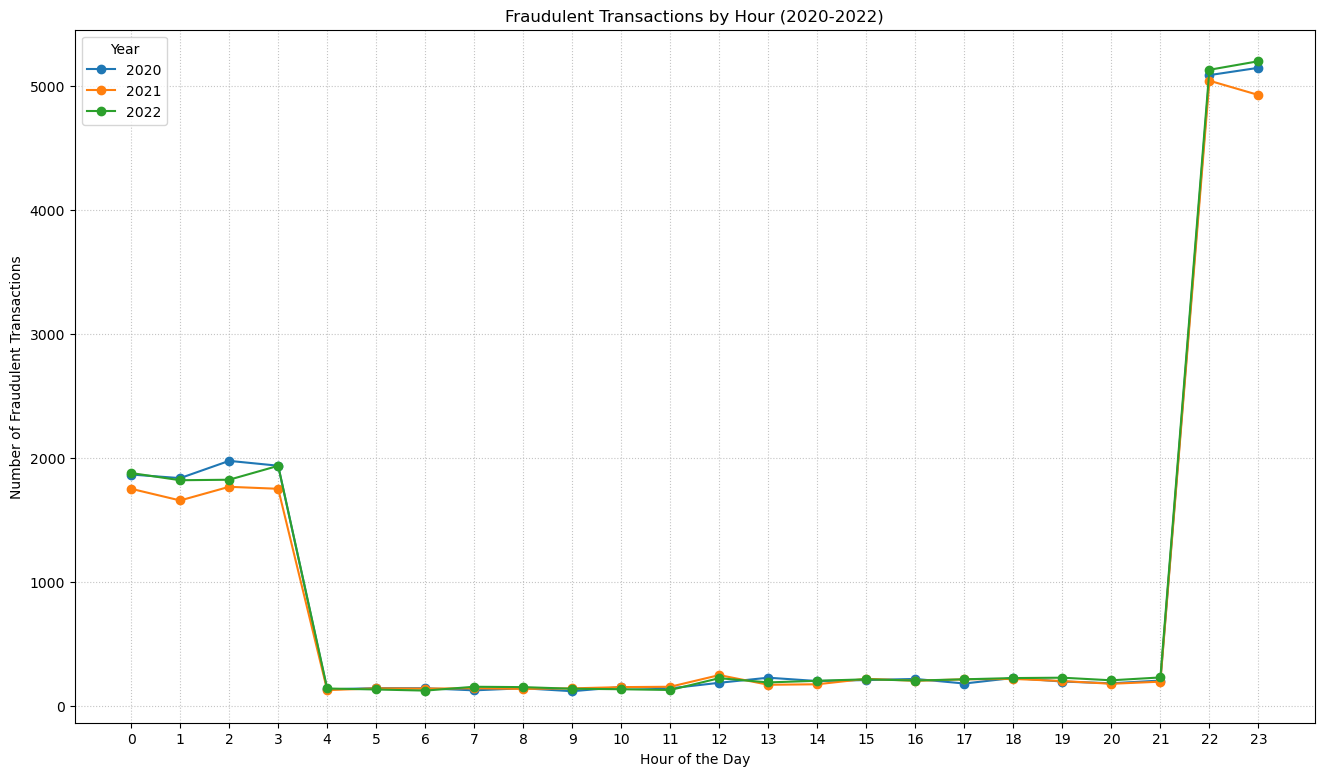

In [16]:
# Filtering transactions for the years 2020-2022
filtered_transactions = transactions_df.filter((col("trans_year").between(2020, 2022)) & (col("is_fraud") == 1))

# Aggregating the number of fraudulent transactions every hour for each year
fraud_by_hour_per_year = filtered_transactions.groupBy("trans_year", "trans_hour") \
                                              .count() \
                                              .orderBy("trans_year", "trans_hour")

# Converting to Pandas for plotting
fraud_by_hour_per_year_pandas = fraud_by_hour_per_year.toPandas()

# Plotting using matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 9))

# Plotting each year separately
# Looping through each unique year in the data
# Creating a subset of data for the current year
# Plotting the number of fraudulent transactions by hour for the current year
for year in fraud_by_hour_per_year_pandas['trans_year'].unique():
    subset = fraud_by_hour_per_year_pandas[fraud_by_hour_per_year_pandas['trans_year'] == year]
    plt.plot(subset['trans_hour'], subset['count'], marker='o', label=f'{year}')

plt.xlabel('Hour of the Day')
plt.ylabel('Number of Fraudulent Transactions')
plt.title('Fraudulent Transactions by Hour (2020-2022)')
plt.xticks(range(0, 24)) 
plt.legend(title='Year')
plt.grid(axis='y', linestyle=':', alpha=0.75)
plt.grid(axis='x', linestyle=':', alpha=0.75)
plt.show()

Observations:

This line plot visualizes the number of fraudulent transactions per hour of the day, aggregated separately for each year from 2020 to 2022. Let's break down the key observations:

Hour of the Day:
The x-axis represents the hours of the day (0-23), where 0 corresponds to midnight, and 23 corresponds to 11 PM.
The y-axis shows the total number of fraudulent transactions that occurred at each hour of the day.

General Trends Across Years:

Midnight to 2 AM: There is a consistent number of fraudulent transactions across all three years during the early hours (midnight to 2 AM). The number of fraudulent transactions is relatively high during this period, with a slight increase around 1 AM.

3 AM to 7 PM: There is a sharp drop in fraudulent activity starting from 3 AM, continuing throughout the day until around 8 PM. The number of fraudulent transactions remains consistently low across these hours.

8 PM to 11 PM: There is a significant and sharp increase in fraudulent transactions around 9 PM, peaking at 11 PM.

Specific Yearly Observations:

2020: The line representing 2020 shows a slightly higher number of fraudulent transactions during the early hours (midnight to 3 AM) compared to the other two years. However, the overall trend mirrors the general trend described above.

2021: This year follows the same pattern as 2020 but shows a slight dip in the number of fraudulent transactions around midnight to 2 AM compared to 2020.

2022: The trend in 2022 is nearly identical to 2021, with only minor variations in the number of fraudulent transactions during peak hours.

Peak Hours for Fraudulent Activity:
The most noticeable peaks in fraudulent activity are at midnight and around 11 PM. This suggests that fraudulent transactions are highly concentrated at these times, potentially indicating a strategy used by fraudsters to exploit certain vulnerabilities during these late hours.

Dip in Activity:
From around 3 AM until the evening (around 9 PM), there is a notable dip in fraudulent transactions. This might reflect a lower volume of overall transactions during these hours, reducing opportunities for fraud, or possibly increased vigilance during business hours.

Implications:
The data suggests that fraudulent transactions are more likely to occur late at night, particularly just after midnight and late in the evening. This might indicate that fraudsters are targeting systems when they assume there is less oversight or during periods of low transaction volumes.

Conclusion:
The graph highlights key patterns in fraudulent transactions over different hours of the day for the years 2020 to 2022. The peak hours suggest potential vulnerabilities in the late-night and early morning periods, which could be crucial for designing targeted fraud prevention strategies during these times.

### Part 3 RDDs vs DataFrame vs Spark SQL <a class="anchor" name="part-3"></a>
Implement the following queries using RDDs, DataFrame in SparkSQL separately. Log the  time taken for each query in each approach using the “%%time” built-in magic command in Jupyter Notebook and discuss the performance difference between these 3 approaches.

#### Query: <strong>We consider city with population < 50K as small(denoted as S); 50K-200K as medium(M), >200K as large(L). For each city type, using customer age bucket of 10(e.g. 0-9, 10-19, 20-29…), show the percentage ratio of fraudulent transactions in each age bucket.</strong>

In [17]:
from pyspark.sql.functions import col, udf
from pyspark.sql.types import StringType
from datetime import datetime

# Defining UDF for population classification based on size
def classify_population(population):
    if population < 50000:
        return "S"
    elif 50000 <= population <= 200000:
        return "M"
    else:
        return "L"

# Defining UDF for classifying age into buckets
def classify_age_bucket(dob):
    current_year = datetime.now().year # Getting the current year
    age = current_year - dob.year # Calculating age based on year of birth
    return f"{age//10*10}-{(age//10*10) + 9}" # Classifying age into 10-year buckets

population_udf = udf(classify_population, StringType())
age_bucket_udf = udf(classify_age_bucket, StringType())

# Joining transactions, customers, and geolocation data
transactions_with_customers_df = transactions_df.join(customers_df, "id_customer") \
                                                .join(geolocation_df, "id_geolocation") \
                                                .withColumn("city_type", population_udf(col("population"))) \
                                                .withColumn("age_bucket", age_bucket_udf(col("dob")))

#### 3.1. RDD Implementation

In [18]:
%%time

from pyspark.sql import Row

# Converting DataFrame to RDD
transactions_rdd = transactions_with_customers_df.rdd


# RDD Implementation
# Mapping each row to a key-value pair with (city_type, age_bucket) as the key and (is_fraud, 1) as the value
# Reducing by key to sum up the fraud counts and total counts for each (city_type, age_bucket)
# Calculating the fraud percentage for each (city_type, age_bucket)
# Sorting the results by city_type and age_bucket

rdd_result = transactions_rdd.map(lambda row: ((classify_population(row['population']), classify_age_bucket(row['dob'])), (row['is_fraud'], 1))) \
                             .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
                             .mapValues(lambda v: (v[0] / v[1]) * 100) \
                             .sortBy(lambda x: (x[0][0], x[0][1])) \
                             .collect()

# Displaying the results in a tabular format
print("+----------------+------------+-------------------------+")
print("| City Type      | Age Bucket | Fraud Percentage (%)     |")
print("+----------------+------------+-------------------------+")

for (city_type, age_bucket), fraud_percentage in rdd_result:
    print(f"| {city_type:<14} | {age_bucket:<10} | {fraud_percentage:<23.3f} |")
    print("+----------------+------------+-------------------------+")


+----------------+------------+-------------------------+
| City Type      | Age Bucket | Fraud Percentage (%)     |
+----------------+------------+-------------------------+
| L              | 20-29      | 0.189                   |
+----------------+------------+-------------------------+
| L              | 30-39      | 0.189                   |
+----------------+------------+-------------------------+
| L              | 40-49      | 0.190                   |
+----------------+------------+-------------------------+
| L              | 50-59      | 0.407                   |
+----------------+------------+-------------------------+
| L              | 60-69      | 0.427                   |
+----------------+------------+-------------------------+
| L              | 70-79      | 0.430                   |
+----------------+------------+-------------------------+
| L              | 80-89      | 0.483                   |
+----------------+------------+-------------------------+
| L          

#### 3.2. DataFrame Implementation

In [19]:
%%time

from pyspark.sql.functions import col, sum as spark_sum, count, when

# Calculating the percentage of fraudulent transactions by city type and age bucket
# Grouping the DataFrame by city type and age bucket
# Aggregating by calculating the fraud percentage and rounding to 3 decimal places
fraud_df = transactions_with_customers_df.groupBy("city_type", "age_bucket") \
    .agg(
        round((spark_sum(when(col("is_fraud") == 1, 1).otherwise(0)) / count("*") * 100), 3).alias("fraud_percentage")
    )

# Ordering the results by city type and age bucket
ordered_fraud_df = fraud_df.orderBy("city_type", "age_bucket")

# Displaying the results
ordered_fraud_df.show(ordered_fraud_df.count(), truncate=False)

+---------+----------+----------------+
|city_type|age_bucket|fraud_percentage|
+---------+----------+----------------+
|L        |20-29     |0.189           |
|L        |30-39     |0.189           |
|L        |40-49     |0.19            |
|L        |50-59     |0.407           |
|L        |60-69     |0.427           |
|L        |70-79     |0.43            |
|L        |80-89     |0.483           |
|L        |90-99     |0.438           |
|M        |20-29     |0.184           |
|M        |30-39     |0.183           |
|M        |40-49     |0.193           |
|M        |50-59     |0.392           |
|M        |60-69     |0.428           |
|M        |70-79     |0.421           |
|M        |80-89     |0.332           |
|M        |90-99     |0.395           |
|S        |20-29     |0.198           |
|S        |30-39     |0.202           |
|S        |40-49     |0.188           |
|S        |50-59     |0.383           |
|S        |60-69     |0.432           |
|S        |70-79     |0.417           |


#### 3.3. Spark SQL Implementation

In [20]:
%%time

# Registering the DataFrame as a temporary SQL view
transactions_with_customers_df.createOrReplaceTempView("transactions_customers")

# Writing and executing the SQL query
# Executing a SQL query to calculate the fraud percentage grouped by city type and age bucket, 
# rounding to 3 decimal places, and ordering the results
fraud_sql_df = spark.sql("""
    SELECT city_type, 
           age_bucket,
           ROUND((SUM(is_fraud) / COUNT(*) * 100), 3) AS fraud_percentage
    FROM transactions_customers
    GROUP BY city_type, age_bucket
    ORDER BY city_type, age_bucket
""")

# Displaying all results without truncation
fraud_sql_df.show(fraud_sql_df.count(), truncate=False)

+---------+----------+----------------+
|city_type|age_bucket|fraud_percentage|
+---------+----------+----------------+
|L        |20-29     |0.189           |
|L        |30-39     |0.189           |
|L        |40-49     |0.19            |
|L        |50-59     |0.407           |
|L        |60-69     |0.427           |
|L        |70-79     |0.43            |
|L        |80-89     |0.483           |
|L        |90-99     |0.438           |
|M        |20-29     |0.184           |
|M        |30-39     |0.183           |
|M        |40-49     |0.193           |
|M        |50-59     |0.392           |
|M        |60-69     |0.428           |
|M        |70-79     |0.421           |
|M        |80-89     |0.332           |
|M        |90-99     |0.395           |
|S        |20-29     |0.198           |
|S        |30-39     |0.202           |
|S        |40-49     |0.188           |
|S        |50-59     |0.383           |
|S        |60-69     |0.432           |
|S        |70-79     |0.417           |


### 3.4 Which one is the easiest to implement in your opinion? Log the time taken for each query, and observe the query execution time, among RDD, DataFrame, SparkSQL, which is the fastest and why? Please include proper reference. (Maximum 500 words.)

### Implementation Ease and Performance Comparison

In my experience, **Spark SQL** is the easiest approach to implement. It allows for writing queries in a SQL-like syntax, which is intuitive and familiar to anyone with experience in traditional databases. This approach abstracts away much of the complexity associated with data processing, such as partitioning and optimization, making it accessible even to users who may not be as familiar with Spark's API.

**DataFrames** come next in terms of ease of use. The DataFrame API offers a higher-level abstraction than RDDs, allowing for operations to be performed in a more declarative manner. This API is particularly powerful because it combines the familiarity of DataFrame operations from languages like Python (Pandas) and R with the optimization benefits of Spark's Catalyst optimizer.

**RDDs**, while offering the most control over data processing, are the most challenging to work with. They require explicit handling of transformations and actions, and managing distributed data efficiently demands a deeper understanding of Spark's internals. This makes RDDs less user-friendly compared to DataFrames and Spark SQL.

### Performance Observation

The performance of each approach, as recorded during the execution of the query, is as follows:

- **RDD**: Wall time: 2min 29s
- **DataFrame**: Wall time: 1min 10s
- **Spark SQL**: Wall time: 1min 10s

Among the three approaches, **Spark SQL** is the fastest, followed closely by DataFrames, while RDDs are significantly slower.

The reason for Spark SQL’s superior performance is primarily due to the Catalyst optimizer, which optimizes the execution plan for SQL queries. This includes predicate pushdowns, query pruning, and other optimizations that reduce the amount of data shuffled across the network and processed by the cluster.

DataFrames benefit from the same underlying optimizations as Spark SQL because they are internally converted to optimized execution plans by the Catalyst optimizer. However, the slight difference in performance between DataFrames and Spark SQL could be attributed to the additional abstraction layers present in the DataFrame API.

On the other hand, RDDs do not benefit from such high-level optimizations. Operations on RDDs are more manual and require explicit control over how data is partitioned and processed. This leads to longer execution times, as Spark cannot automatically optimize the operations as it does with DataFrames and Spark SQL.

### Conclusion

In conclusion, while RDDs offer the most granular control, they are the most challenging to work with and the least performant. DataFrames strike a balance between ease of use and performance, making them suitable for most Spark applications. Spark SQL, however, stands out as the most efficient and easiest to implement for users familiar with SQL, making it the preferred choice for querying large datasets in Spark.

**References:**

- Apache Spark. (n.d.). Spark SQL, DataFrames and Datasets guide. https://spark.apache.org/docs/latest/sql-programming-guide.html
- Kumar, A. (n.d.). Spark RDD vs DataFrame vs Dataset. Medium. https://medium.com/@ashwin_kumar_/spark-rdd-vs-dataframe-vs-dataset-c90f7da18e56
- Databricks. (2016, July 14). A tale of three Apache Spark APIs: RDDs, DataFrames, and Datasets. https://www.databricks.com/blog/2016/07/14/a-tale-of-three-apache-spark-apis-rdds-dataframes-and-datasets.html

### Some ideas on the comparison

Armbrust, M., Huai, Y., Liang, C., Xin, R., & Zaharia, M. (2015). Deep Dive into Spark SQL’s Catalyst Optimizer. Retrieved September 30, 2017, from https://databricks.com/blog/2015/04/13/deep-dive-into-spark-sqls-catalyst-optimizer.html

Damji, J. (2016). A Tale of Three Apache Spark APIs: RDDs, DataFrames, and Datasets. Retrieved September 28, 2017, from https://databricks.com/blog/2016/07/14/a-tale-of-three-apache-spark-apis-rdds-dataframes-and-datasets.html

Data Flair (2017a). Apache Spark RDD vs DataFrame vs DataSet. Retrieved September 28, 2017, from http://data-flair.training/blogs/apache-spark-rdd-vs-dataframe-vs-dataset

Prakash, C. (2016). Apache Spark: RDD vs Dataframe vs Dataset. Retrieved September 28, 2017, from http://why-not-learn-something.blogspot.com.au/2016/07/apache-spark-rdd-vs-dataframe-vs-dataset.html

Xin, R., & Rosen, J. (2015). Project Tungsten: Bringing Apache Spark Closer to Bare Metal. Retrieved September 30, 2017, from https://databricks.com/blog/2015/04/28/project-tungsten-bringing-spark-closer-to-bare-metal.html